## GENERAL SETUP

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.planets import PlanetModel
from gallifrey.utilities.dataframe import rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    contour_plot,
)

## PLOT SETUP

In [4]:
print(
    "RIDGE PLOT 1: ALL CATEGORIES AT ONE FIXED [FE/H] AND OTHER VARIABLES SAMPLED -> INTRINSIC VARIATIONS UNRELATED TO METALLICITY"
)
print(
    "RIDGE PLOT 2: ONE CATEGORY, ALL VARIABLES SAMPLES, DIFFERENT STAR MASSES -> VARIATIONS WITH STAR MASS (VERY DIFFERENT FOR DIFFERENT CATEGORIES, NEED ANOTHER PLOT TO SHOW THAT"
)
print(
    "ADD MODEL WHERE METALLICITIES BELOW -0.5 GET 0 PLANETS, SEE HOW MUCH THAT CHANGES (PHRASE IT AS TWO EXTREMES)"
)

RIDGE PLOT 1: ALL CATEGORIES AT ONE FIXED [FE/H] AND OTHER VARIABLES SAMPLED -> INTRINSIC VARIATIONS UNRELATED TO METALLICITY
RIDGE PLOT 2: ONE CATEGORY, ALL VARIABLES SAMPLES, DIFFERENT STAR MASSES -> VARIATIONS WITH STAR MASS (VERY DIFFERENT FOR DIFFERENT CATEGORIES, NEED ANOTHER PLOT TO SHOW THAT
ADD MODEL WHERE METALLICITIES BELOW -0.5 GET 0 PLANETS, SEE HOW MUCH THAT CHANGES (PHRASE IT AS TWO EXTREMES)


In [5]:
set_plot_defaults()
figure_directory = "Planet_model"

## REDUCING DIMENSIONALITY

In [6]:
num_samples = int(1e5)

num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)
population_id = planet_model.get_population_id(num_embryos, host_star_mass)

categories = [
    category
    for category in planet_model.categories
    if category not in ["Dwarf", "D-Burner"]
]
included_variables = ("log_initial_mass", "[Fe/H]")

### Creating Sample of included Monte Carlo Variables

In [7]:
bounds = {
    variable: planet_model.get_systems(population_id).bounds[variable]
    for variable in included_variables
}
samples = np.column_stack(
    [np.random.uniform(bound[0], bound[1], num_samples) for bound in bounds.values()]
)
samples = pd.DataFrame(samples, columns=bounds.keys())

### Compare behaviour of full and reduced model

In [8]:
prediction_parameter_dict = {
    "categories": categories,
    "host_star_mass": host_star_mass,
    "variables": samples,
    "return_full": False,
}

full_model = planet_model.prediction(**prediction_parameter_dict)
reduced_model = planet_model.prediction(
    **prediction_parameter_dict, included_variables=included_variables
)
model_difference = full_model - reduced_model

model_difference.describe()

,Earth,Super-Earth,Neptunian,Sub-Giant,Giant
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.229446,0.357562,0.004334,0.006752,-0.040321
std,0.975565,0.890859,0.252401,0.088295,0.168177
min,-4.200000,-3.666667,-1.433333,-0.633333,-1.133333
25%,-0.333333,-0.133333,-0.033333,0.000000,-0.033333
50%,0.166667,0.366667,0.000000,0.000000,0.000000
75%,0.766667,0.900000,0.100000,0.033333,0.000000
max,4.700000,4.366667,1.200000,0.566667,0.700000


## HYPERPARAMETER TUNING

In [9]:
# recreate original sample
original_variables = planet_model.get_systems(population_id).variables
original_sample = planet_model.prediction(
    categories,
    host_star_mass,
    variables=original_variables,
    return_full=True,
    neighbors=1,
)

In [10]:
# checking for optimal number of neighbors using k-fold cross-validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

X = original_sample[list(included_variables)]
X_scaled = StandardScaler().fit_transform(X)
y = original_sample[categories]

# perform cross validation on data
neighbors = range(1, 101)  # Checking for neighbors from 1 to 100
cv_scores = []  # cross validation scores
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled, y, cv=10)  # Using 10-fold CV
    cv_scores.append(np.mean(scores))

print(f"The optimal number of neighbors is: {neighbors[np.argmax(cv_scores)]}")

The optimal number of neighbors is: 30


## INTERPOLATION BEHAVIOUR

In [26]:
num_bins = 100

num_embryos = 50
host_star_mass = 1

planet_model = PlanetModel(num_embryos)
population_id = planet_model.get_population_id(num_embryos, host_star_mass)

category = "Earth"
included_variables = ("log_initial_mass", "[Fe/H]")

### Grid of Monte Carlo Variables

In [27]:
variable_grid = planet_model.get_systems(population_id).variable_grid(
    num_bins, included_variables=included_variables, as_dataframe=True
)

variable_grid[category] = planet_model.prediction(
    category,
    host_star_mass,
    variables=variable_grid,
    included_variables=included_variables,
    return_full=False,
    neighbors=30,
)

variable_grid, variable_labels = rename_labels(variable_grid)

In [32]:
print("Make big plot with all categories")
print(
    "Why sort of linear, why shifting with mass? should I quantify that? probabaly to do with the fact that disc mass is product of both quantities, read up in formation paper how planetsimals grow again"
)
print(
    "Maybe reparametrize model in terms of solid mass. or at least give rough rule for that"
)

Make big plot with all categories
Why sort of linear, why shifting with mass? should I quantify that? probabaly to do with the fact that disc mass is product of both quantities, read up in formation paper how planetsimals grow again


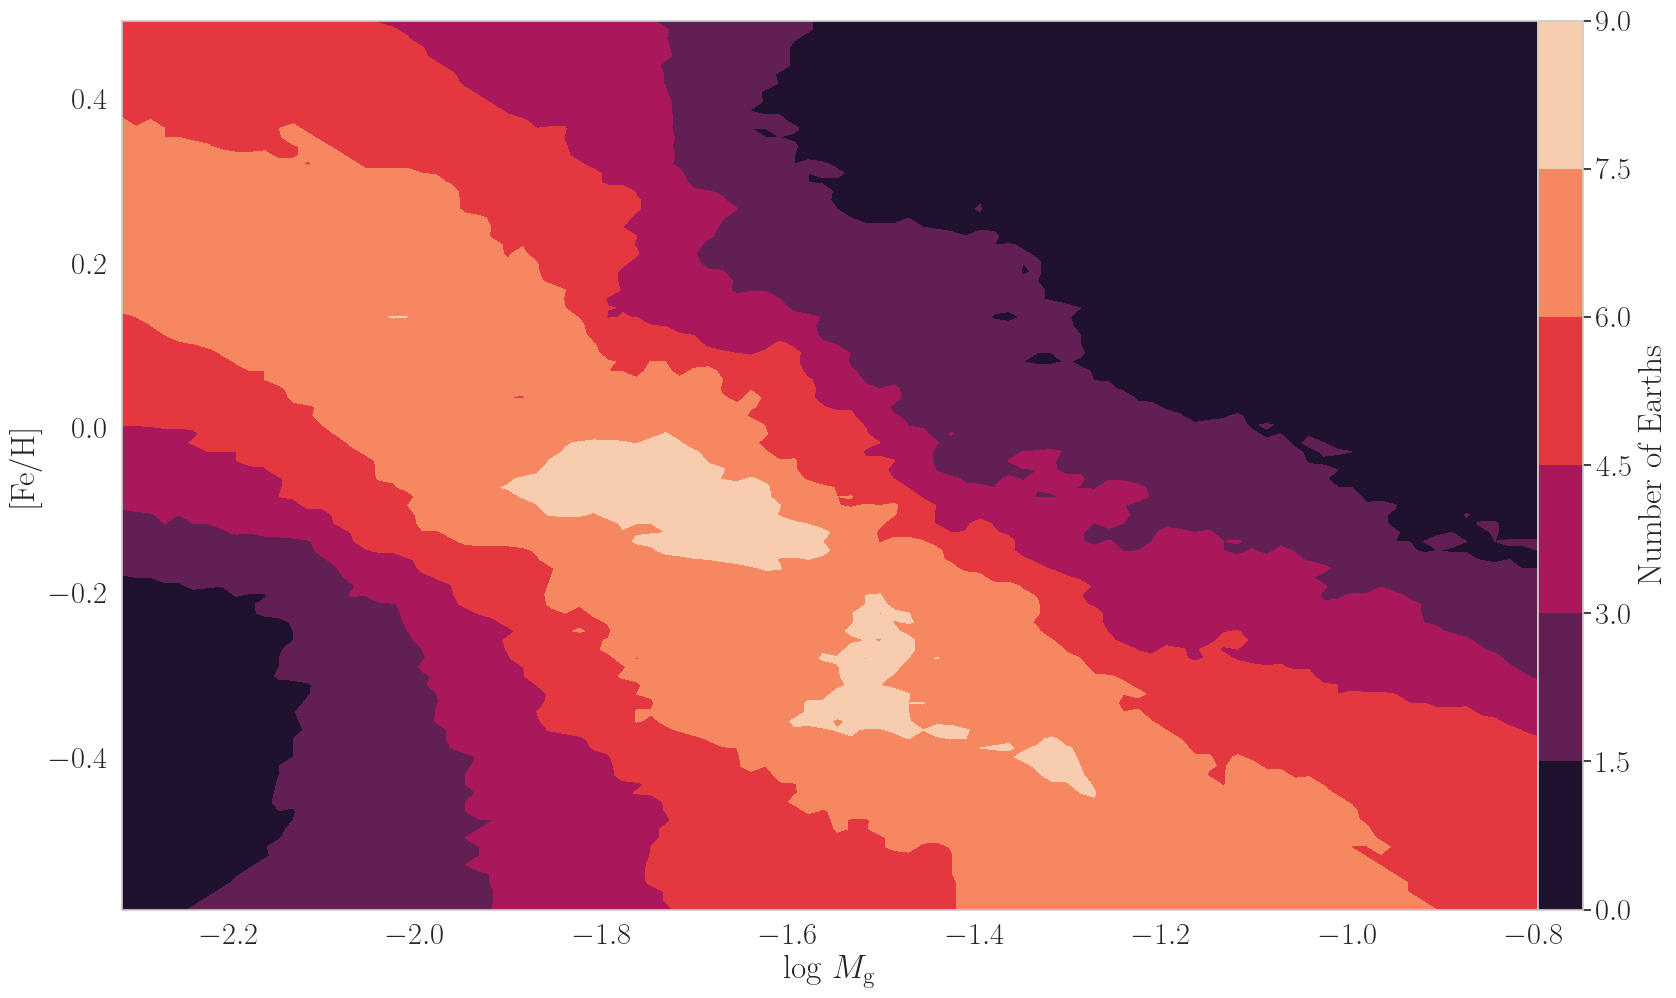

In [33]:
contourplot = contour_plot(
    *variable_labels,
    hue=category,
    data=variable_grid,
    reshaping_bins=num_bins,
    colorbar_label=f"Number of {category}s",
)
FigureProcessor(contourplot.figure).save(
    "contourplot.pdf", sub_directory=figure_directory
)